### Imports

In [8]:
import time
import selfies
import rdkit
import random
import numpy as np
import random
from rdkit import Chem
from selfies import encoder, decoder
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import Mol
from rdkit.Chem.AtomPairs.Sheridan import GetBPFingerprint, GetBTFingerprint
from rdkit.Chem.Pharm2D import Generate, Gobbi_Pharm2D
from rdkit.Chem import Draw

from rdkit.Chem import MolToSmiles as mol2smi
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

def randomize_smiles(mol):
    '''Returns a random (dearomatized) SMILES given an rdkit mol object of a molecule.
    Parameters:
    mol (rdkit.Chem.rdchem.Mol) :  RdKit mol object (None if invalid smile string smi)

    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object  (None if invalid smile string smi)
    '''
    if not mol:
        return None

    Chem.Kekulize(mol)
    return rdkit.Chem.MolToSmiles(mol, canonical=False, doRandom=True, isomericSmiles=False,  kekuleSmiles=True)


def sanitize_smiles(smi):
    '''Return a canonical smile representation of smi

    Parameters:
    smi (string) : smile string to be canonicalized

    Returns:
    mol (rdkit.Chem.rdchem.Mol) : RdKit mol object                          (None if invalid smile string smi)
    smi_canon (string)          : Canonicalized smile representation of smi (None if invalid smile string smi)
    conversion_successful (bool): True/False to indicate if conversion was  successful
    '''
    try:
        mol = smi2mol(smi, sanitize=True)
        smi_canon = mol2smi(mol, isomericSmiles=False, canonical=True)
        return (mol, smi_canon, True)
    except:
        return (None, None, False)


def get_selfie_chars(selfie):
    '''Obtain a list of all selfie characters in string selfie

    Parameters:
    selfie (string) : A selfie string - representing a molecule

    Example:
    >>> get_selfie_chars('[C][=C][C][=C][C][=C][Ring1][Branch1_1]')
    ['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[Branch1_1]']

    Returns:
    chars_selfie: list of selfie characters present in molecule selfie
    '''
    chars_selfie = [] # A list of all SELFIE sybols from string selfie
    while selfie != '':
        chars_selfie.append(selfie[selfie.find('['): selfie.find(']')+1])
        selfie = selfie[selfie.find(']')+1:]
    return chars_selfie


class _FingerprintCalculator:
    ''' Calculate the fingerprint for a molecule, given the fingerprint type
    Parameters:
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)
    Returns:
        RDKit fingerprint object
    '''

    def get_fingerprint(self, mol: Mol, fp_type: str):
        method_name = 'get_' + fp_type
        method = getattr(self, method_name)
        if method is None:
            raise Exception(f'{fp_type} is not a supported fingerprint type.')
        return method(mol)

    def get_AP(self, mol: Mol):
        return AllChem.GetAtomPairFingerprint(mol, maxLength=10)

    def get_PHCO(self, mol: Mol):
        return Generate.Gen2DFingerprint(mol, Gobbi_Pharm2D.factory)

    def get_BPF(self, mol: Mol):
        return GetBPFingerprint(mol)

    def get_BTF(self, mol: Mol):
        return GetBTFingerprint(mol)

    def get_PATH(self, mol: Mol):
        return AllChem.RDKFingerprint(mol)

    def get_ECFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2)

    def get_ECFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3)

    def get_FCFP4(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 2, useFeatures=True)

    def get_FCFP6(self, mol: Mol):
        return AllChem.GetMorganFingerprint(mol, 3, useFeatures=True)


def get_fingerprint(mol: Mol, fp_type: str):
    ''' Fingerprint getter method. Fingerprint is returned after using object of
        class '_FingerprintCalculator'

    Parameters:
        mol (rdkit.Chem.rdchem.Mol) : RdKit mol object (None if invalid smile string smi)
        fp_type (string)            :Fingerprint type  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)
    Returns:
        RDKit fingerprint object

    '''
    return _FingerprintCalculator().get_fingerprint(mol=mol, fp_type=fp_type)

def mutate_selfie(selfie, max_molecules_len, write_fail_cases=False):
    '''Return a mutated selfie string (only one mutation on slefie is performed)

    Mutations are done until a valid molecule is obtained
    Rules of mutation: With a 33.3% propbabily, either:
        1. Add a random SELFIE character in the string
        2. Replace a random SELFIE character with another
        3. Delete a random character

    Parameters:
    selfie            (string)  : SELFIE string to be mutated
    max_molecules_len (int)     : Mutations of SELFIE string are allowed up to this length
    write_fail_cases  (bool)    : If true, failed mutations are recorded in "selfie_failure_cases.txt"

    Returns:
    selfie_mutated    (string)  : Mutated SELFIE string
    smiles_canon      (string)  : canonical smile of mutated SELFIE string
    '''
    valid=False
    fail_counter = 0
    chars_selfie = get_selfie_chars(selfie)

    while not valid:
        fail_counter += 1

        alphabet = list(selfies.get_semantic_robust_alphabet()) # 34 SELFIE characters

        choice_ls = [1, 2, 3] # 1=Insert; 2=Replace; 3=Delete
        random_choice = np.random.choice(choice_ls, 1)[0]

        # Insert a character in a Random Location
        if random_choice == 1:
            random_index = np.random.randint(len(chars_selfie)+1)
            random_character = np.random.choice(alphabet, size=1)[0]

            selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index:]

        # Replace a random character
        elif random_choice == 2:
            random_index = np.random.randint(len(chars_selfie))
            random_character = np.random.choice(alphabet, size=1)[0]
            if random_index == 0:
                selfie_mutated_chars = [random_character] + chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + [random_character] + chars_selfie[random_index+1:]

        # Delete a random character
        elif random_choice == 3:
            random_index = np.random.randint(len(chars_selfie))
            if random_index == 0:
                selfie_mutated_chars = chars_selfie[random_index+1:]
            else:
                selfie_mutated_chars = chars_selfie[:random_index] + chars_selfie[random_index+1:]

        else:
            raise Exception('Invalid Operation trying to be performed')

        selfie_mutated = "".join(x for x in selfie_mutated_chars)
        sf = "".join(x for x in chars_selfie)

        try:
            smiles = decoder(selfie_mutated)
            mol, smiles_canon, done = sanitize_smiles(smiles)
            if len(selfie_mutated_chars) > max_molecules_len or smiles_canon=="":
                done = False
            if done:
                valid = True
            else:
                valid = False
        except:
            valid=False
            if fail_counter > 1 and write_fail_cases == True:
                f = open("selfie_failure_cases.txt", "a+")
                f.write('Tried to mutate SELFIE: '+str(sf)+' To Obtain: '+str(selfie_mutated) + '\n')
                f.close()

    return (selfie_mutated, smiles_canon)

def get_mutated_SELFIES(selfies_ls, num_mutations):
    ''' Mutate all the SELFIES in 'selfies_ls' 'num_mutations' number of times.

    Parameters:
    selfies_ls   (list)  : A list of SELFIES
    num_mutations (int)  : number of mutations to perform on each SELFIES within 'selfies_ls'

    Returns:
    selfies_ls   (list)  : A list of mutated SELFIES

    '''
    for _ in range(num_mutations):
        selfie_ls_mut_ls = []
        for str_ in selfies_ls:

            str_chars = get_selfie_chars(str_)
            max_molecules_len = len(str_chars) + num_mutations

            selfie_mutated, _ = mutate_selfie(str_, max_molecules_len)
            selfie_ls_mut_ls.append(selfie_mutated)

        selfies_ls = selfie_ls_mut_ls.copy()
    return selfies_ls


def get_fp_scores(smiles_back, target_smi, fp_type):
    '''Calculate the Tanimoto fingerprint (using fp_type fingerint) similarity between a list
       of SMILES and a known target structure (target_smi).

    Parameters:
    smiles_back   (list) : A list of valid SMILES strings
    target_smi (string)  : A valid SMILES string. Each smile in 'smiles_back' will be compared to this stucture
    fp_type (string)     : Type of fingerprint  (choices: AP/PHCO/BPF,BTF,PAT,ECFP4,ECFP6,FCFP4,FCFP6)

    Returns:
    smiles_back_scores (list of floats) : List of fingerprint similarities
    '''
    smiles_back_scores = []
    target    = Chem.MolFromSmiles(target_smi)

    fp_target = get_fingerprint(target, fp_type)

    for item in smiles_back:
        mol    = Chem.MolFromSmiles(item)
        fp_mol = get_fingerprint(mol, fp_type)
        score  = TanimotoSimilarity(fp_mol, fp_target)
        smiles_back_scores.append(score)
    return smiles_back_scores

### Visualize space

In [9]:
smi     = "COC1=C(OCCCN2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C=C3)=NC=NC2=C1"
fp_type = 'ECFP4'


total_time = time.time()
num_random_samples = 3000 # For a more exhaustive search!
# num_random_samples = 1000
num_mutation_ls    = [1, 2, 3, 4, 5]

mol = Chem.MolFromSmiles(smi)
if mol == None:
    raise Exception('Invalid starting structure encountered')

start_time = time.time()
randomized_smile_orderings  = [randomize_smiles(mol) for _ in range(num_random_samples)]

# Convert all the molecules to SELFIES
selfies_ls = [encoder(x) for x in randomized_smile_orderings]
print('Randomized molecules (in SELFIES) time: ', time.time()-start_time)


all_smiles_collect = []
all_smiles_collect_broken = []

start_time = time.time()
for num_mutations in num_mutation_ls:
    # Mutate the SELFIES:
    selfies_mut = get_mutated_SELFIES(selfies_ls.copy(), num_mutations=num_mutations)

    # Convert back to SMILES:
    smiles_back = [decoder(x) for x in selfies_mut]
    all_smiles_collect = all_smiles_collect + smiles_back
    all_smiles_collect_broken.append(smiles_back)


print('Mutation obtainment time (back to smiles): ', time.time()-start_time)


# Work on:  all_smiles_collect
start_time = time.time()
canon_smi_ls = []
for item in all_smiles_collect:
    mol, smi_canon, did_convert = sanitize_smiles(item)
    if mol == None or smi_canon == '' or did_convert == False:
        raise Exception('Invalid smile string found')
    canon_smi_ls.append(smi_canon)
canon_smi_ls        = list(set(canon_smi_ls))
print('Unique mutated structure obtainment time: ', time.time()-start_time)

start_time = time.time()
canon_smi_ls_scores = get_fp_scores(canon_smi_ls, target_smi=smi, fp_type=fp_type)
print('Fingerprint calculation time: ', time.time()-start_time)
print('Total time: ', time.time()-total_time)

# Molecules with fingerprint similarity > 0.8
indices_thresh_8 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.8]
mols_8 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_8]

# Molecules with fingerprint similarity > 0.6
indices_thresh_6 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.6 and x < 0.8]
mols_6 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_6]

# Molecules with fingerprint similarity > 0.4
indices_thresh_4 = [i for i,x in enumerate(canon_smi_ls_scores) if x > 0.4 and x < 0.6]
mols_4 = [Chem.MolFromSmiles(canon_smi_ls[idx]) for idx in indices_thresh_4]

Randomized molecules (in SELFIES) time:  0.9759232997894287
Mutation obtainment time (back to smiles):  22.625340938568115
Unique mutated structure obtainment time:  2.5486388206481934
Fingerprint calculation time:  2.2476279735565186
Total time:  28.398683071136475


In [10]:
# img=Draw.MolsToGridImage(mols_4[:8],molsPerRow=4,subImgSize=(200,200))
# img

### Model

In [11]:
import tensorflow as tf
import pandas as pd
from molgraph.models import GradientActivationMapping
from molgraph.chemistry import vis
import medchem as mc
from helpers import encode, encoder

model_file = "../saved_models/GCNII"
model = tf.keras.models.load_model(model_file)

In [ ]:
smiles = np.take(np.array(canon_smi_ls), indices_thresh_4)
df = pd.DataFrame({
    "smiles": smiles,
    "mol": [Chem.MolFromSmiles(i) for i in smiles],
    "inchi": [Chem.MolToInchi(Chem.MolFromSmiles(i)) for i in smiles]
})
# df["preds"] = model.predict(encoder(df.inchi.values))
df["rule_of_five"] = df["smiles"].apply(mc.rules.basic_rules.rule_of_five)
df["rule_of_ghose"] = df["smiles"].apply(mc.rules.basic_rules.rule_of_ghose)
df["rule_of_veber"] = df["smiles"].apply(mc.rules.basic_rules.rule_of_veber)
df["rule_of_zinc"] = df["smiles"].apply(mc.rules.basic_rules.rule_of_zinc)
df["filters_NIBR"] = mc.functional.nibr_filter(
    mols=df["mol"].tolist(),
    n_jobs=-1,
    progress=True,
    return_idx=False,
)
df = df.query("rule_of_five==True and rule_of_ghose==True and rule_of_veber==True and rule_of_zinc==True and filters_NIBR==True")
df["preds"] = model.predict(encoder(df.inchi.values))


In [13]:
df = df.sort_values(by="preds", ascending=True).query("preds >= 0.9")
df

,smiles,mol,inchi,rule_of_five,rule_of_ghose,rule_of_veber,rule_of_zinc,filters_NIBR,preds
553,CNC(OCCCN1CCOCC1)=C(C=C1CC(Nc2ccc(F)c(Cl)c2)=N...,<rdkit.Chem.rdchem.Mol object at 0x31aae2420>,InChI=1S/C22H29ClFN5O3/c1-25-22(32-9-3-6-29-7-...,True,True,True,True,True,0.900392
1489,COc1cc2c(cc1OCC1NCOCC1C)C(Nc1ccc(F)c(Cl)c1)=[C...,<rdkit.Chem.rdchem.Mol object at 0x31aafc190>,InChI=1S/C22H22ClFN3O3/c1-13-10-29-12-26-20(13...,True,True,True,True,True,0.901273
2043,COC1=C(NCCCN2CCOCC2)CC(Nc2ccc(F)c(Cl)c2)C(N=CN...,<rdkit.Chem.rdchem.Mol object at 0x31d10b5a0>,InChI=1S/C21H29ClFN5O2/c1-29-21-13-18(26-14-24...,True,True,True,True,True,0.904217
266,Fc1ccc(NCC=c2ncncc2=C[N+]OCCCN2CCOCC2)cc1Cl,<rdkit.Chem.rdchem.Mol object at 0x310af4820>,InChI=1S/C20H24ClFN5O2/c21-18-12-17(2-3-19(18)...,True,True,True,True,True,0.904362
910,COc1cc2c(cc1OCCCN1CCOCC1)[B+]CN(c1ccc(F)c(Cl)c...,<rdkit.Chem.rdchem.Mol object at 0x31aaec200>,InChI=1S/C22H26BClFN4O3/c1-30-21-13-20-17(12-2...,True,True,True,True,True,0.905539
...,...,...,...,...,...,...,...,...,...
406,COc1cc2ncnc(Nc3bc(Cl)c(F)cc3)c2cc1OCC#[B-]NCC[O-],<rdkit.Chem.rdchem.Mol object at 0x3118f6340>,InChI=1S/C18H16B2ClFN4O3/c1-28-14-9-13-11(8-15...,True,True,True,True,True,1.000000
588,COc1cc2ncnc(Nc3[o+]c(Cl)cbc3F)c2cc1[B-]=CCCN1C...,<rdkit.Chem.rdchem.Mol object at 0x31aae3370>,InChI=1S/C20H21B2ClFN4O3/c1-29-16-10-15-13(9-1...,True,True,True,True,True,1.000000
1003,FCO[b-]1cc2ncnc(NC3C#SC=C3)c2cc1OCCCN1CCOCC1,<rdkit.Chem.rdchem.Mol object at 0x31aaeeab0>,InChI=1S/C19H23BFN4O3S/c21-13-28-20-11-17-16(1...,True,True,True,True,True,1.000000
151,BC1COCCN1COc1cc2c(cc1OC)N=C[B-]C2Nc1ccc(F)c(Cl)c1,<rdkit.Chem.rdchem.Mol object at 0x12f721930>,InChI=1S/C20H22B2ClFN3O3/c1-28-17-8-16-13(7-18...,True,True,True,True,True,1.000000


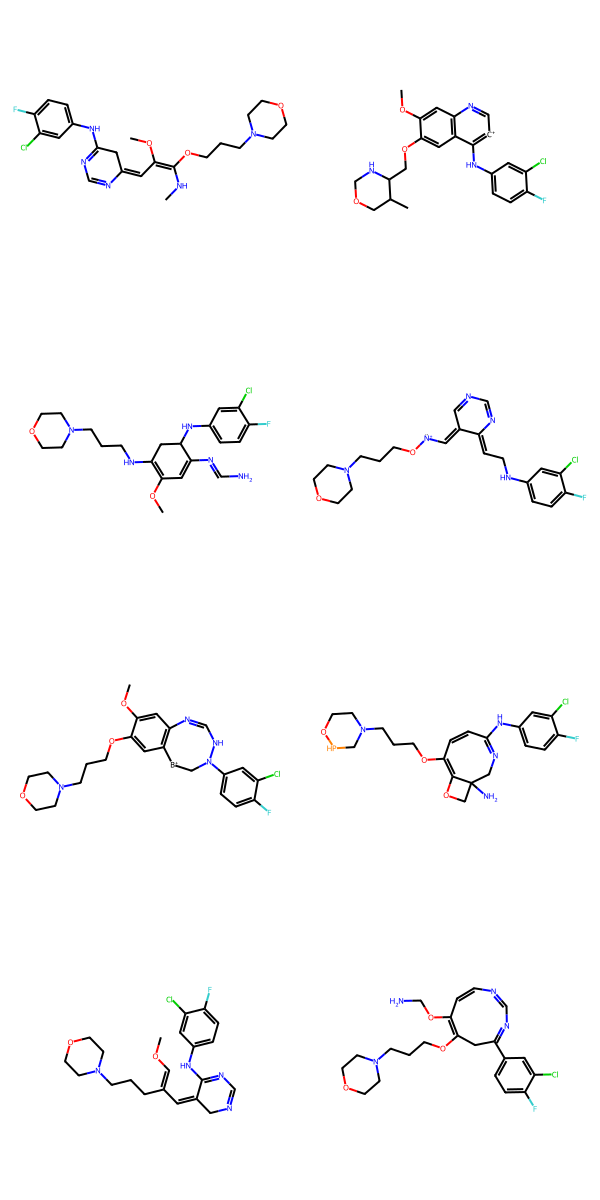

In [16]:
img=Draw.MolsToGridImage(df.mol[:8],molsPerRow=2,subImgSize=(300,300))
img